In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

In [3]:
# Train and test data will be loaded
metadata_train_df = pd.read_csv('train/hwg_metadata.csv')
measurements_train_df = pd.read_csv("train/measurements.csv")
metadata_test_df = pd.read_csv('test/hwg_metadata.csv')
measurements_test_df = pd.read_csv("test/measurements.csv")

In [4]:
# Data Preprocessing
merged_train_df = pd.merge(measurements_train_df, metadata_train_df, on='subject_id')
merged_test_df = pd.merge(measurements_test_df, metadata_test_df, on='subject_id')
cleaned_train_df = merged_train_df.drop(['height_cm', 'subject_id'], axis=1)
cleaned_test_df = merged_test_df.drop(['height_cm', 'subject_id'], axis=1)
label_encoder = LabelEncoder()
cleaned_train_df['gender'] = label_encoder.fit_transform(cleaned_train_df['gender'])
cleaned_test_df['gender'] = label_encoder.fit_transform(cleaned_test_df['gender'])

features_train = cleaned_train_df.drop('weight_kg', axis=1)
target_train = cleaned_train_df['weight_kg']
features_test = cleaned_test_df.drop('weight_kg', axis=1)
target_test = cleaned_test_df['weight_kg']

scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(features_train)
scaled_features_test = scaler.transform(features_test)

In [5]:
# Visualzization of scaled fetures on the test data
scaled_features_test_df = pd.DataFrame(scaled_features_test, columns=features_test.columns)
scaled_features_test_df.head()

,ankle,arm-length,bicep,calf,chest,forearm,height,hip,leg-length,shoulder-breadth,shoulder-to-crotch,thigh,waist,wrist,gender
0,-0.410688,-0.787471,-0.172231,0.126136,-0.277246,-0.315135,-0.391576,-0.134221,-0.847937,0.479230,-0.064086,-0.286807,-0.212941,-0.357344,0.810441
1,-0.387970,-0.346460,-0.468351,-1.115944,-0.482745,-0.632152,0.113036,-0.421468,-0.414099,-0.154675,0.254345,-1.048973,-0.354894,-0.367275,0.810441
2,-1.327390,-1.419911,-1.257912,-1.347536,-1.453101,-1.734764,-1.572019,-1.382177,-1.227402,-1.708434,-1.914485,-1.493351,-1.375575,-1.542464,-1.233896
3,-0.578533,-0.599981,-0.708576,-0.280311,-1.526592,-1.128809,-0.735006,-0.177098,-0.305384,-1.557977,-1.032714,-0.348517,-1.045699,-0.732931,-1.233896
4,-1.001800,-0.866868,0.756722,-0.536278,1.200650,-0.481383,-0.707168,0.467068,-0.638431,-0.926443,-0.368156,0.610917,0.820728,-0.624814,-1.233896


## Fitting a model without PCA

In [10]:
linear_reg = LinearRegression()
linear_reg.fit(scaled_features_train, target_train)

# Predicting on the test data
predictions_no_pca = linear_reg.predict(scaled_features_test)

# Evaluating the model
mse_no_pca = mean_squared_error(target_test, predictions_no_pca)
mae_no_pca = mean_absolute_error(target_test, predictions_no_pca)
r2_no_pca = r2_score(target_test, predictions_no_pca)

mse_no_pca, mae_no_pca, r2_no_pca

(9.519707968942534, 2.1547636933874452, 0.9734757282698714)

## Fitting a model wit PCA

In [7]:
pca = PCA(n_components=scaled_features_train.shape[1])
pca.fit(scaled_features_train)

pca_transformed_train = pca.transform(scaled_features_train)
pca_transformed_test = pca.transform(scaled_features_test)

# Displaying the variance ratio explained by the first few components
pca.explained_variance_ratio_[:5]


array([0.63068671, 0.19473418, 0.05655154, 0.03314555, 0.02182843])

In [8]:
# Function for applying Linear Regression to reduced data with different components
def fit_and_evaluate_pca_model(k, pca_transformed_train_data, train_target, pca_transformed_test_data, test_target):
    # Using the first K components
    reduced_train_features = pca_transformed_train_data[:, :k]
    reduced_test_features = pca_transformed_test_data[:, :k]

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(reduced_train_features, train_target)

    # Predicting and evaluating the model
    predictions = model.predict(reduced_test_features)
    mse = mean_squared_error(test_target, predictions)
    mae = mean_absolute_error(test_target, predictions)
    r2 = r2_score(test_target, predictions)

    return mse, mae, r2

In [9]:
# Creating dataframe for each K and corresponding metrics
k_values = [1, 2, 3, 4, 5]
pca_metrics = {'K': [], 'MSE': [], 'MAE': [], 'R2': []}

for k in k_values:
    mse, mae, r2 = fit_and_evaluate_pca_model(k, pca_transformed_train, target_train, pca_transformed_test, target_test)
    pca_metrics['K'].append(k)
    pca_metrics['MSE'].append(mse)
    pca_metrics['MAE'].append(mae)
    pca_metrics['R2'].append(r2)

# Converting metrics to a DataFrame for better visualization
pca_metrics_df = pd.DataFrame(pca_metrics)
pca_metrics_df

,K,MSE,MAE,R2
0,1,33.064122,4.187822,0.907875
1,2,14.339080,2.788670,0.960048
2,3,13.233823,2.661936,0.963127
3,4,10.700932,2.358744,0.970185
4,5,9.835015,2.232707,0.972597


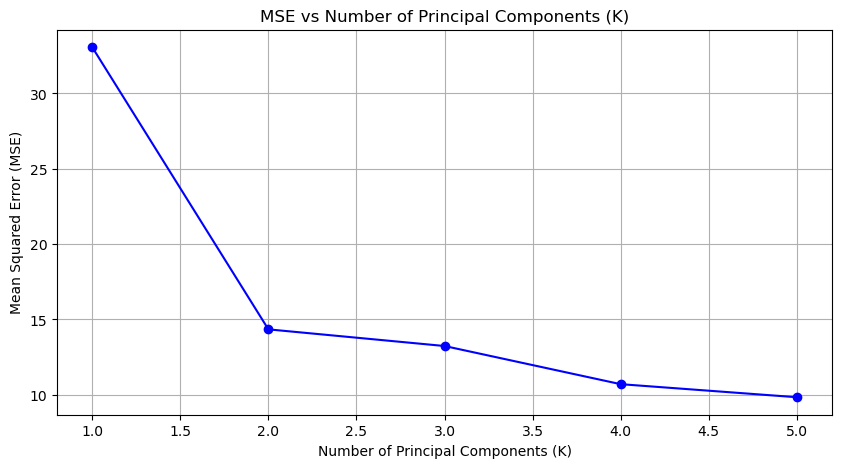

In [10]:
#MSE vs Number of Principal Components (K) graph
plt.figure(figsize=(10, 5))
plt.plot(pca_metrics_df['K'], pca_metrics_df['MSE'], 'o-', color='blue')
plt.title('MSE vs Number of Principal Components (K)')
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

#### We can see that there is sharp decrease in MSE until 2 first 2 component, then rate of decrease is slowed down
#### We should choose K in a way that it should still capture enough varience and providing computational efficens by without adding unnecessary complexity
#### As we can see from the above graph, If we choose K as 2 we can still capture enough information and there is no signifiact effect of increasing K 